<a href="https://colab.research.google.com/github/E-NAK/Music-Recommendation-System/blob/main/Part_4_Spectrograms_and_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# 此内容为代码格式
```

# Part 4: Spectrograms and PCA!

![Spotify logo](https://drive.google.com/uc?id=1WsaRSK8pVfoEzI0BwZQcXCzhXBfQbI8m)

In this notebook, we'll be taking a closer look at our audio data using tools like spectrograms and performing PCA!

In [3]:
#@title Run this to download data and prepare the environment. (Restart runtime and rerun cell in case of an error) { display-mode: "form" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# new dependencies
!pip install requests --upgrade
!pip install urllib3 --upgrade
!pip install spotipy --upgrade
!pip install traces

import spotipy
import requests
from spotipy.oauth2 import SpotifyClientCredentials
import traces

# do not change these codes
client_credentials_manager = SpotifyClientCredentials('e316c18604cb42399f3b679791362112','4bd95a0d37d145998cfdcaf2a68579d7')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# machine learning models
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# audio analysis
import librosa
import librosa.display
!pip install audio2numpy
!apt-get install ffmpeg
import audio2numpy
import IPython.display as ipd
from IPython.display import YouTubeVideo

# helper function to plot a timbre timecourse
def plot_timbre(df, song_id, timbre_col):
    col = f'timbre_{timbre_col}'
    plt.figure()
    plt.plot([i*.5 for i in range(len(df[col][song_id]))], df[col][song_id])
    plt.xlabel('time/seconds')
    plt.ylabel('timbre component weight')

# timbre timecourses
# data_url = 'https://drive.google.com/uc?id=1jwG1B98Uq5phurfGmdZg8w2BCJdth6Io'
!wget -O ./spotify_data_timbre.csv = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/spotify_data_timbre.csv'
data_path = './spotify_data_timbre.csv'

# chirp file
# chirp_url = 'https://drive.google.com/uc?id=1iX6wV0cSGIVM0nTItTSUlUehhKCILymB'
!wget -O ./chirp.wav = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/chirp.wav'
chirp_path = './chirp.wav'

# two wav files
# wav1_url = 'https://drive.google.com/uc?id=14qA48pPVJKU4KlP8YwqTpDo7WEewjXwf'
!wget -O ./sample1.wav = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/track_3504.wav'
wav1_path = './sample1.wav'

# wav2_url = 'https://drive.google.com/uc?id=12XIWhMCAiabzGqXQhN2wB9o5p6MFR4Y0'
!wget -O ./sample2.wav = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/track_3642.wav'
wav2_path = './sample2.wav'

# Check that the data downloaded by running this cell! It'll have more columns than usual.
data = pd.read_csv(data_path)
data.rename(columns={'Unnamed: 0':'orig_index'},inplace=True)
data.drop(columns=['index'],inplace=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=e7ea64bc0e872b907e5966b2795dfcba741ebfa552aeb62a40bf5aac5dc1bcb7
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
--2024-12-22 01:35:17--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2024-12-22 01:35:17--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/spotify_data_timbre.csv
Resolving storage.googleapis.com (storage.goog

## Outline of notebook
Here's what we're going to cover today:
1. Learn about spectrograms.
2. Learn about principal component analysis.
3. Explore how these are related to Spotify's timbre components.

# Spectrograms
### Background
Sound is essentially made of a bunch of **waves**, which are oscillations of the air at different **frequencies** or rates. When playing a tone at just a single frequency, these air particle oscillations trace a waveform known as a **sine** wave. You can see this in the video below, which plays a sine tone that continuously rises in pitch:

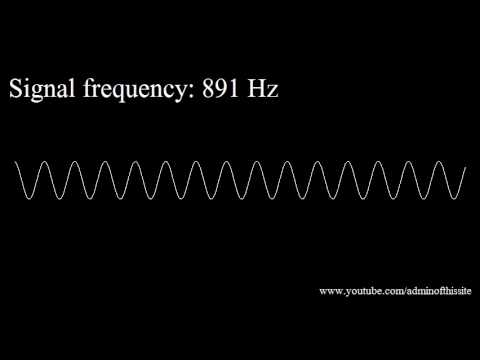

In [5]:
YouTubeVideo('qNf9nzvnd1k')

Usually, however, sounds are made up of lots of individual sine waves at different frequencies and **amplitudes** (loudnesses), and the waveform looks a lot more complex than this.

For example, when you look at an audio file for a song in a digital format, you can see how the waveform is super complex. Let's see what that looks like on a sample audio file that's taken from our dataset.

First, let's play it:

In [6]:
ipd.Audio(wav1_path) # this uses a library called IPython.display

We'll use a package called **librosa** to visualise what the audio looks like. The code below will display the amplitude varying over time.

In [8]:
# load in the audio file
audio, fs = librosa.load(wav1_path)
librosa.display.waveplot(audio)
plt.show()

AttributeError: module 'librosa.display' has no attribute 'waveplot'

In [ ]:
#@title Can you relate what's happening in the audio file to this waveform?
your_answer = ''  #@param {type:"string"}
print(your_answer)

In [ ]:
#@title Instructor solution hidden

print("Ans: it's difficult to relate the two because there are no big changes in amplitude throughout the sample.")

For context, here's a much simpler sound -- a sine tone that gets continuously higher in pitch and louder in amplitude -- and its corresponding waveform, which is also simpler to understand.

In [ ]:
ipd.Audio(chirp_path)

In [ ]:
# load in the audio file
audio1, fs1 = librosa.load(chirp_path)
plt.figure(figsize=(20,4))
librosa.display.waveplot(audio1)
plt.ylabel("Amplitude")
plt.show()

You still can't really see the frequencies, though: you can only see the amplitude changing over time. It would be nice, to have a sense of what frequencies are present in the sound, and **how strong** or loud they are relative to other frequencies.

In order to do this, we can run something called a **Discrete Fourier Transform** or DFT on the waveform. The math behind DFTs is rather complex, but if you want to find out more you can check out [this great book](https://ccrma.stanford.edu/~jos/st/) by Julius Smith, a Stanford professor of Music Technology and Electrical Engineering.

Once you perform this DFT, you can generate spectrograms, which show you how the different frequencies in the sound fluctuate over time. Let's make one for ourselves. There are a few steps to this, so read the comments to find out more!

First, let's do it for the audio chirp.

In [ ]:
# perform short-time fourier transform (this makes the raw spectrogram)
D = librosa.stft(audio1)

# display the spectrogram
fig, ax = plt.subplots()
img = librosa.display.specshow(D, ax=ax, x_axis='time', y_axis='log')
fig.colorbar(img, ax=ax, label="Amplitude")
fig.set_size_inches(20,10)

In [ ]:
#@title How does this compare to the amplitude plot?
your_answer = '' #@param {type:"string"}
print(your_answer)

We can also convert our amplitude scale to decibels (a different unit) to be able to see more information about the sound! With a different scale, you can see the sound is a bit more complex but the primary waves are still the brightest.

In [ ]:
# perform short-time fourier transform (this makes the raw spectrogram)
D = librosa.stft(audio1)

# convert the amplitude to decibel scale
# specgram_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
specgram_db = librosa.amplitude_to_db(np.abs(D), ref = np.max(D))

# display the spectrogram
fig, ax = plt.subplots()
img = librosa.display.specshow(specgram_db, ax=ax, x_axis='time', y_axis='log')
fig.colorbar(img, ax=ax, label="Amplitude")
fig.set_size_inches(20,10)

Now let's do it for the song, which is going to be more complex.

In [ ]:
# perform short-time fourier transform (this makes the raw spectrogram)
D = librosa.stft(audio)

# display the spectrogram
fig, ax = plt.subplots()
img = librosa.display.specshow(D, ax=ax, x_axis='time', y_axis='log')
fig.colorbar(img, ax=ax)
fig.set_size_inches(20,10)

Here, you can look at it in decibels!

In [ ]:
# perform short-time fourier transform (this makes the raw spectrogram)
D = librosa.stft(audio)

# convert the amplitude to decibel scale (to make everything easier to see)
specgram_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# display the spectrogram
fig, ax = plt.subplots()
img = librosa.display.specshow(specgram_db, ax=ax, x_axis='time', y_axis='log')
fig.colorbar(img, ax=ax)
fig.set_size_inches(20,10)

How does this compare with the amplitude plot? What features can you make out in this spectrogram? Play the song again if you need to.

In [ ]:
#@title How does this compare to the amplitude plot?
your_answer = '' #@param {type:"string"}
print(your_answer)

In [ ]:
#@title Instructor solution hidden
print("Ans: you can see the saxophone solo around six seconds in -- everything else drops out of the music! \nAlso near the end (c. 25 seconds) you can see the long sustained note in the sax part. \nOvertones can be seen (lots of squiggly lines the same distance apart moving in the same direction). \nBut it's still kind of tricky to see everything super clearly.")

Now, see if you can perform all the above steps on another audio file, whose file path is stored in the variable **wav2_path**. Here's what it sounds like:


In [ ]:
ipd.Audio(wav2_path)

Specifically, you should:
1. Load the audio file into librosa (using different variable names from before).
2. Display its waveform using librosa.
3. Make a spectrogram and display it (both using librosa; again use different variable names from before).

Use the code above to help you!

In [ ]:
### YOUR ANSWER HERE

In [ ]:
#@title Instructor solution hidden
# waveform
audio2, _ = librosa.load(wav2_path)
librosa.display.waveplot(audio2)
plt.show()

#spectrogram
# perform short-time fourier transform (this makes the raw spectrogram)
D2 = librosa.stft(audio2)

# convert the amplitude to decibel scale (to make everything easier to see)
specgram_db2 = librosa.amplitude_to_db(np.abs(D2), ref=np.max)

# display the spectrogram
fig, ax = plt.subplots()
img = librosa.display.specshow(specgram_db2, ax=ax, x_axis='time', y_axis='log')
fig.colorbar(img, ax=ax)
fig.set_size_inches(20,10)

Comment on the differences between this spectrogram and the last one.

In [ ]:
### YOUR ANSWER HERE
#

In [ ]:
#@title Instructor solution hidden
print("Ans: the texture is generally a lot thinner; you can see the rhythmic regularity too \n",
      "No clear breaks in the instrumentation like in the last one")

# Principal components analysis
Because the spectrograms contain a lot of information, it would be useful to reduce the number of dimensions down to a manageable number of components. We can do this using **principal components analysis (PCA)**. PCA identifies the directions of greatest variance in a dataset and orders them in terms of the proportion of variance they explain. Each direction is **orthogonal** or perpendicular to each other.

We can understand PCA using a simple example. Let's suppose that John, Mike and Kate get the following percentages for exams in Math, Science, English and Music as follows:

        Math    Science    English    Music    
    John  80        85          60       55  
    Mike  90        85          70       45
    Kate  95        80          40       50

In the table above, can you easily plot the data in a 2D graph? No, because there are four subjects (which means four variables: Math, Science, English, and Music), i.e.:

You could plot two subjects in the exact same way you would with 𝑥 and 𝑦 co-ordinates in a 2D graph.
You could even plot three subjects in the same way you would plot 𝑥, 𝑦 and 𝑧 in a 3D graph (though this is generally bad practice, because some distortion is inevitable in the 2D representation of 3D data).
But how would you plot 4 subjects?

At the moment we have four variables which each represent just one subject. So a method around this might be to somehow combine the subjects into maybe just **two** new variables which we can then plot. This is the idea of PCA.

You can still run PCA on fewer dimensions, though. We're going to look at an example of how it works on 2D data.

In [ ]:
#@title Run this to generate some slightly noisy linearly related data and plot it.
rng = np.random.RandomState(0)
n_samples = 500
cov = [[3, 3],
       [2, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1])
plt.gca().set(aspect='equal',xlabel='x1',ylabel='x2')
plt.show()

We can see in this plot that there's a rough linear relationship between the two features x1 and x2. The greatest axis of variance goes from the bottom left to top right (that's the direction that has the greatest range from one end to the other), while the second greatest axis goes perpendicular to that. The PCA will identify this; let's see how that happens.

In [ ]:
# run PCA
pca = PCA().fit(X)
pca

In [ ]:
#@title Let's now see what the principal components are capturing.
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1])
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)): # this line of code means: get the actual PC vector and the amount of variance it explains
    comp = comp * var  # scale component by its variance explanation power
    print((comp[0]**2 + comp[1]**2)**(0.5))
    # then plot it as a line on top of the data
    plt.plot([0, comp[0]], [0, comp[1]], label=f"component {i}", linewidth=5,
             color=f"C{i + 2}")
plt.gca().set(xlabel='x1', ylabel='x2',aspect='equal')
plt.legend()
plt.show()

We can even re-plot the data using the principal components as the new axes. This can be achieved using the `fit_transform` function as follows:

In [ ]:
X_new = PCA().fit_transform(X)

# plot
plt.figure(figsize=(6,6))
plt.scatter(X_new[:,0],X_new[:,1])
plt.plot([0,5.77],[0,0],color="C2",linewidth=5)
plt.plot([0,0],[0,0.98],color="C3",linewidth=5)
plt.gca().set(xlabel='pc1',ylabel='pc2',aspect='equal')
plt.show()

**Question**: What's the relationship between the original scatterplot and the PC-transformed scatterplot?

In [ ]:
### YOUR ANSWER HERE
#

In [ ]:
#@title Instructor solution hidden
print("It's a rotation of the original!")

In this case, since there are only two features in the original dataset ($x1$ and $x2$), you can't get more than two principal components out. However, our spectrograms have many more than 2 frequencies, so we will have access to more components than before. Let's see what we're working with here:

In [ ]:
print(f'Number of frequency bins: {specgram_db.shape[0]}')

This means we can get up to **1025 principal components**!

In practice, this is far too much. Our goal is to minimize the number of dimensions that we need. It's often standard practice to only use as many components as is necessary to explain **90%** of the variance of a dataset. To do this, we can pass in a parameter to the PCA function in the following way:

`pca = PCA(n_components=.9).fit(___)`

Use this code to fit a PCA to `specgram_db` which we generated earlier on the first example audio file. Save this in a variable called `pca_specgram`.

**Note:** You will need to *transpose* your spectrogram by using `specgram_db.T`. This is because otherwise it'll calculate the PCA over the timesteps, but we want it to be calculated over the frequencies.

In [ ]:
### YOUR CODE HERE
pca_specgram = None # change this!

In [ ]:
#@title Instructor solution hidden
pca_specgram = PCA(n_components=.9).fit(specgram_db.T)

Now let's see how many components were required to get to 90% variance.

In [ ]:
print(f'number of components needed for 90% variance: {pca_specgram.n_components_}')

That's way less than 1025! This is a good sign, as it means we can reconstruct our data with way fewer features. This saves memory and hence increases the speed of any machine learning algorithm we might want to use.

Here's a function to plot a principal component (PC). A PC plot essentially shows the magnitudes of each frequency bin in each component. Use this function in a for loop to plot the first 5 PCs.

In [ ]:
# pc plotting function
def plot_pc(pc_idx):
    pc_fig, pc_ax = plt.subplots()
    pc_ax = sns.heatmap([pca_specgram.components_[pc_idx]])
    pc_fig.set_size_inches(10,2)
    pc_ax.set_xlabel('frequency bin index')
    pc_ax.set_yticklabels('')
    pc_ax.set_title(f'PC{pc_idx+1}')
    plt.show()

### YOUR CODE HERE (for loop here)

### END CODE

In [ ]:
#@title Instructor solution hidden
def plot_pc(pc_idx):
    pc_fig, pc_ax = plt.subplots()
    pc_ax = sns.heatmap([pca_specgram.components_[pc_idx]])
    pc_fig.set_size_inches(10,2)
    pc_ax.set_xlabel('frequency bin index')
    pc_ax.set_yticklabels('')
    pc_ax.set_title(f'PC{pc_idx+1}')
    plt.show()

for i in range(5):
    plot_pc(i)

How can you characterize each of the first 5 PCs?

In [ ]:
### YOUR ANSWER HERE
#

In [ ]:
#@title Instructor solution hidden
print('PC1: broad band low frequency intensity')
print('PC2: similar but more contrast at each end of the band')
print('PC3: mid-range and some high-range')
print('PC4: quite spread out; mix of low, mid and high')
print('PC5: possibly measuring intensity at particular octaves')

We can even project the PCs back onto the original spectrogram to see what effect that has on the visualization. Here's some code to achieve that:

In [ ]:
mu = np.mean(specgram_db.T, axis=0)
specgram_db_pc = np.matmul(pca_specgram.transform(specgram_db.T), pca_specgram.components_)
specgram_db_pc = specgram_db_pc + mu
specgram_db_pc = specgram_db_pc.T

fig, ax = plt.subplots()
img = librosa.display.specshow(specgram_db_pc, ax=ax, x_axis='time', y_axis='log')
fig.colorbar(img, ax=ax)
fig.set_size_inches(20,10)

How does this compare to the first spectrogram we plotted?

In [ ]:
### YOUR ANSWER HERE
#

In [ ]:
#@title Instructor solution hidden
print("They're pretty similar but the PC-transformed version is more diffuse.")

## Spotify's timbre components
While we can calculate the PCs in the way we saw above, it's a pretty involved process to run that code for every single song in our dataset.

Luckily for us, Spotify has done the hard work and given us the twelve **timbre components** we saw earlier. These are essentially the basis principal components of a large number of audio files.

A reminder of what the basis components look like:

![timbre basis components](https://drive.google.com/uc?id=1oRc5W4Rc_iwTZ3GpiIrWqswiPTpkfWkx)

It's a little tricky to intepret what they represent, but the good thing is that there are only 12 of them, as opposed to the thousands of frequency bins we were working with.


## Finished!